In [1]:
import sys

import xarray as xr
import matplotlib.pyplot as plt
import xgcm
import gcm_filters
import argparse
from dask.diagnostics import ProgressBar
import os
import sys
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Compare December January coarsegraining

In [87]:
old = xr.open_dataset('/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/output/prog_full.nc').isel(Time=243).load()

In [90]:
new = xr.open_dataset('/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/high_frequency/time_29.nc').load()

In [92]:
restart_example = xr.open_dataset('/scratch/pp2681/mom6/Feb2022/bare/R2/RESTART/MOM.res.nc')[['u', 'v', 'h', 'sfc']].load().squeeze()
topography_restart = (restart_example.sfc - restart_example.h.sum('Layer')).values

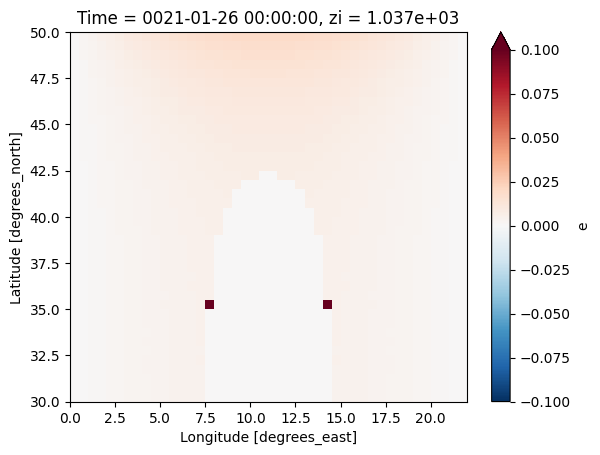

In [99]:
(old.e[2] - new.e[2]).plot(vmin=-1e-1)

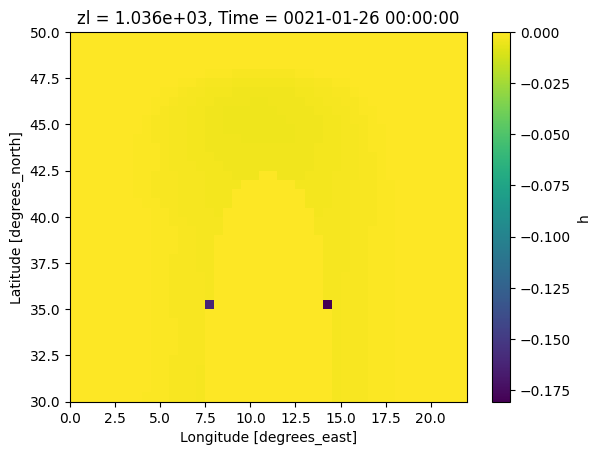

In [117]:
(old.h[1] - new.h[1]).plot()

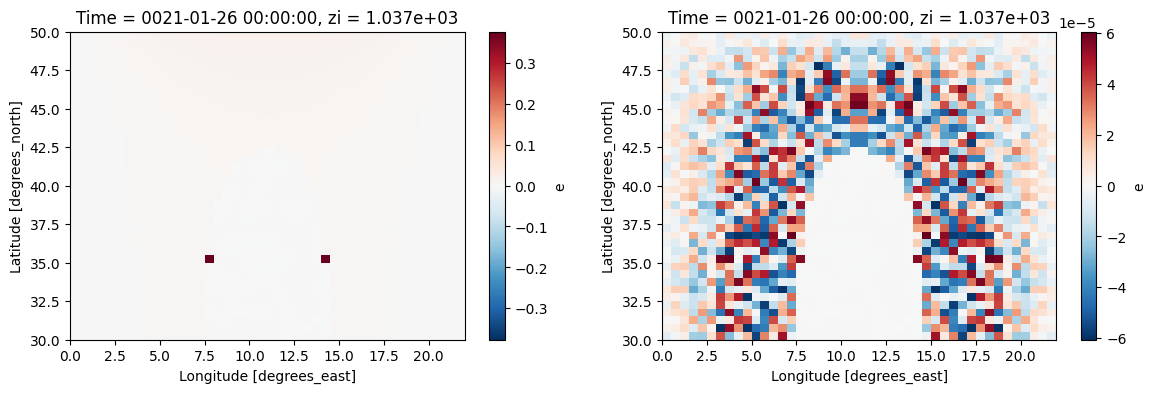

In [100]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
(old.e[2] - topography_restart).plot()

plt.subplot(1,2,2)
(new.e[2] - topography_restart).plot()

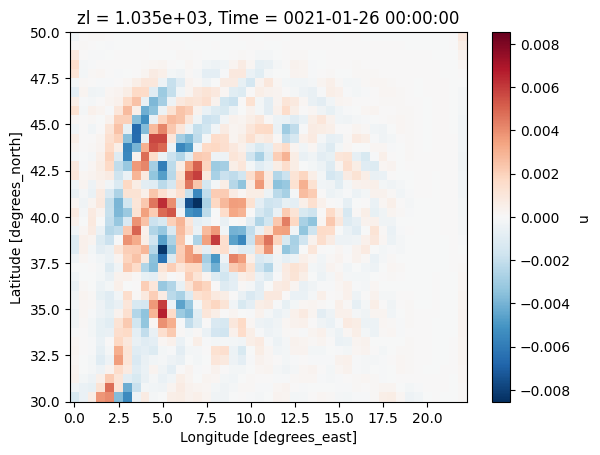

In [101]:
(old.u - new.u)[0].plot()

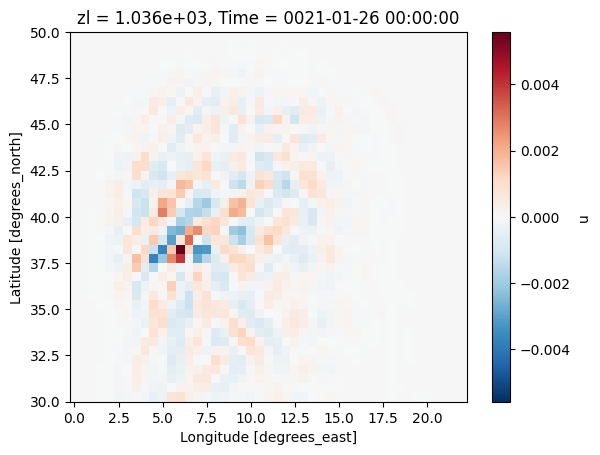

In [102]:
(old.u - new.u)[1].plot()

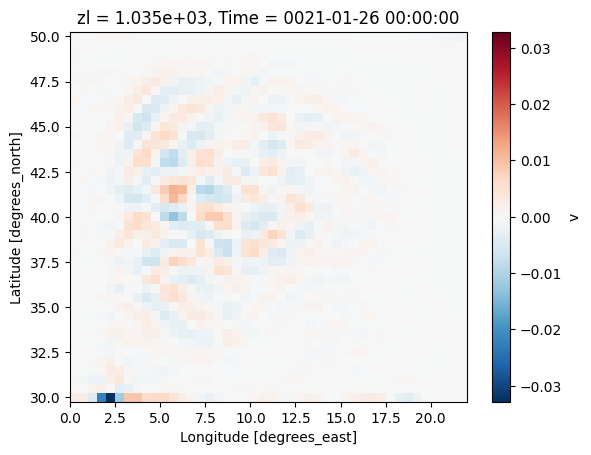

In [103]:
(old.v - new.v)[0].plot()

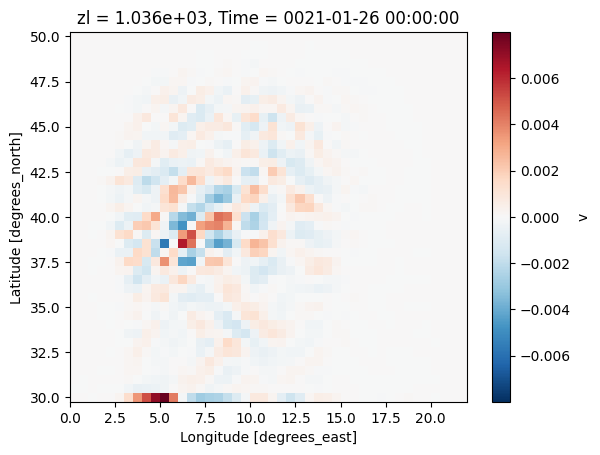

In [104]:
(old.v - new.v)[1].plot()

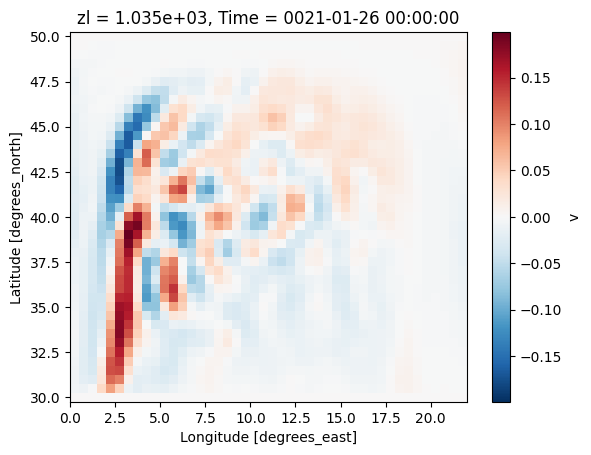

In [107]:
(old.v)[0].plot()

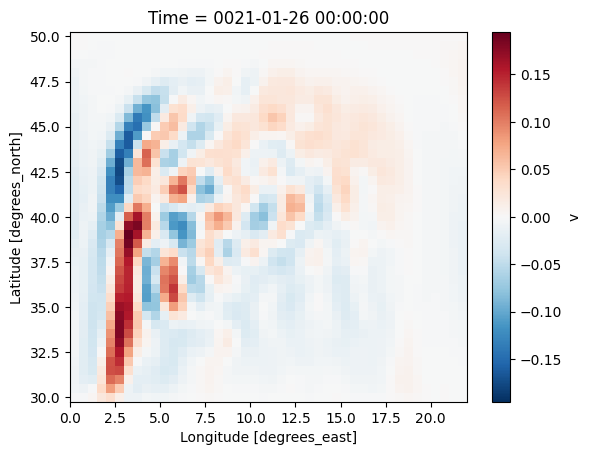

In [108]:
(new.v)[0].plot()

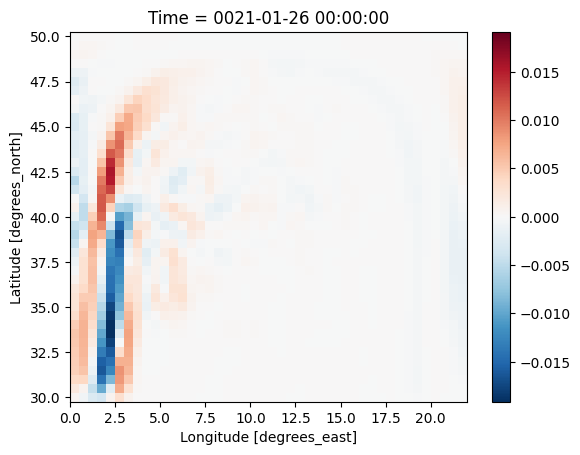

In [109]:
(new.v - new.v_h)[0].plot()

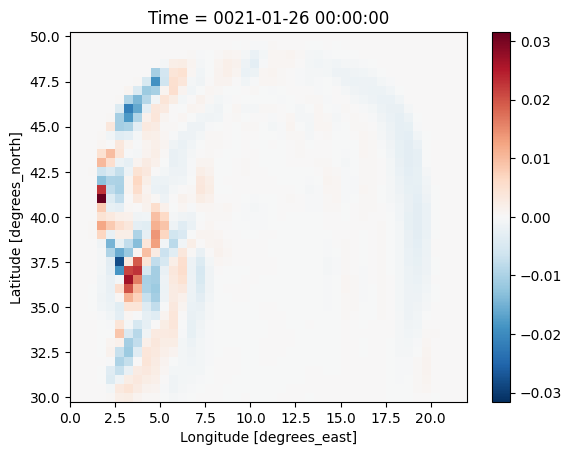

In [110]:
(new.v - new.v_h)[1].plot()

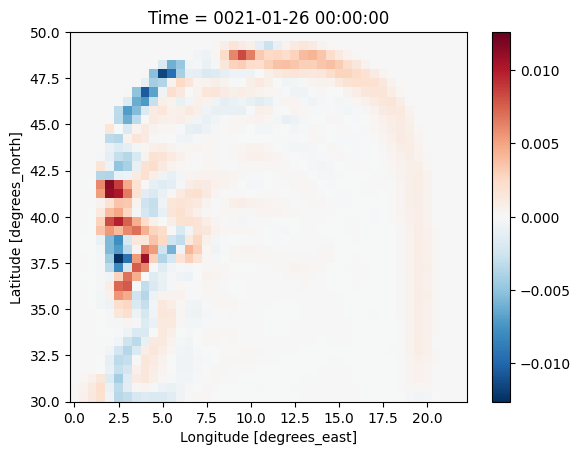

In [111]:
(new.u - new.u_h)[1].plot()

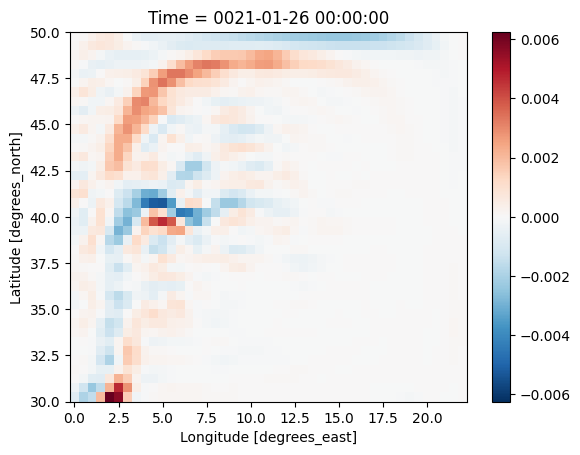

In [112]:
(new.u - new.u_h)[0].plot()

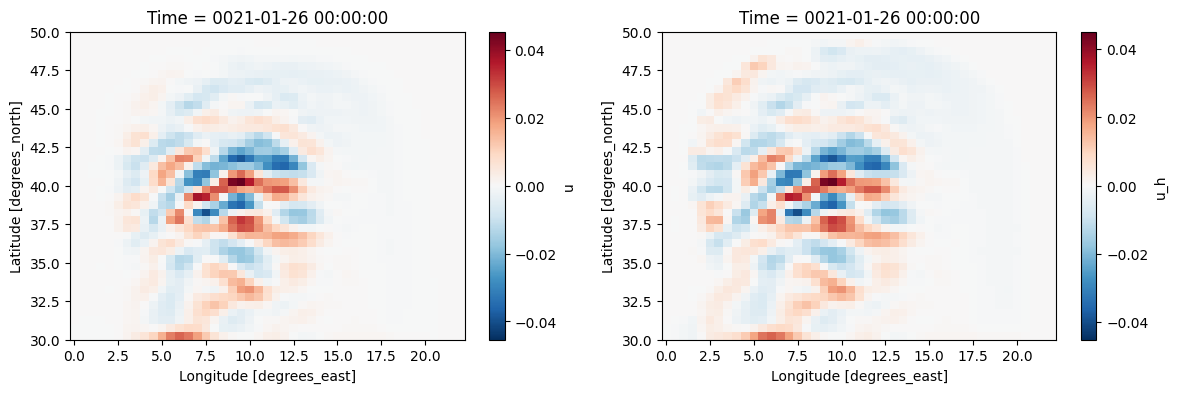

In [120]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
new.u[1].plot()
plt.subplot(1,2,2)
new.u_h[1].plot()

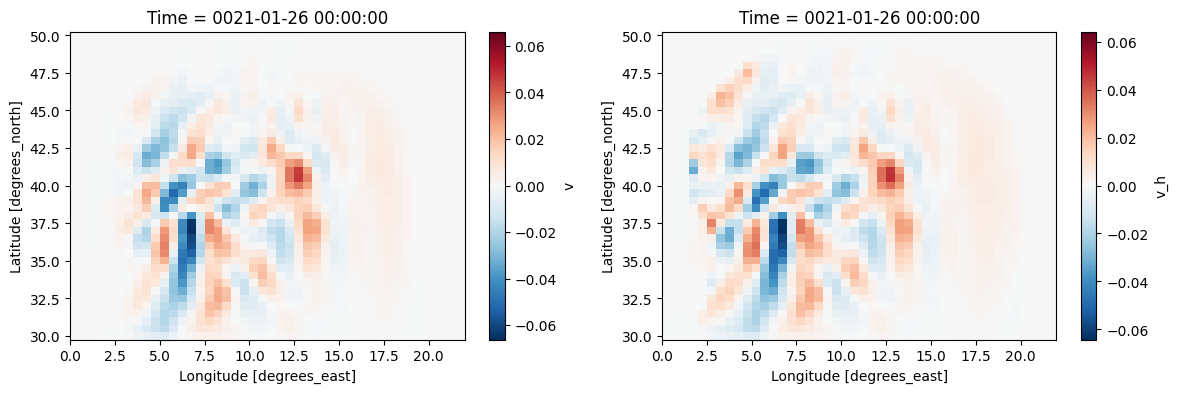

In [121]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
new.v[1].plot()
plt.subplot(1,2,2)
new.v_h[1].plot()

# Prepare restart files TWA and non-TWA

In [55]:
#for time_idx in range(0,1):
time_idx = 900
data = xr.open_dataset(f'/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/high_frequency/time_{time_idx}.nc', decode_times=False).astype('float64').rename({'xh': 'lonh', 'yh': 'lath', 'xq': 'lonq', 'yq': 'latq', 'zl': 'Layer'}).fillna(0.).drop_vars('Time').expand_dims('Time').rename({'e': 'sfc'}).isel(zi=0).drop_vars('zi')

non_TWA = data[['u', 'v', 'h', 'sfc']]
TWA = data[['u_h', 'v_h', 'h', 'sfc']].rename({'u_h': 'u', 'v_h': 'v'})
non_TWA.transpose('Time',...).to_netcdf(f'/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/RESTART_non_TWA/MOM_{time_idx}.res.nc')
TWA.transpose('Time',...).to_netcdf(f'/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/RESTART_TWA/MOM_{time_idx}.res.nc')

# Analyze predictions

In [2]:
data = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/high_frequency/*.nc', decode_times=False, combine='nested', concat_dim='Time').astype('float64').fillna(0.).sortby('Time')
data['Time'] = data['Time'] -  data['Time'].isel(Time=0)

In [3]:
nonTWA = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/R2-non-TWA/prog_*', decode_times=False)
TWA = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/R2-TWA/prog_*', decode_times=False)
eANN_nonTWA = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/eANN-non-TWA/prog_*', decode_times=False)
#eANN_TWA = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/eANN-TWA/prog_*', decode_times=False)
eANN_calibrated_nonTWA = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/eANN-calibrated-non-TWA/prog_*', decode_times=False)

In [4]:
eANN_v1 = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/eANN-calibrated-20-days-u/prog_*', decode_times=False)
eANN_v2 = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/eANN-calibrated-20-days-u-h-weighted/prog_*', decode_times=False)
eANN_v3 = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/eANN-calibrated-20-days-u-h-weighted-full/prog_*', decode_times=False)

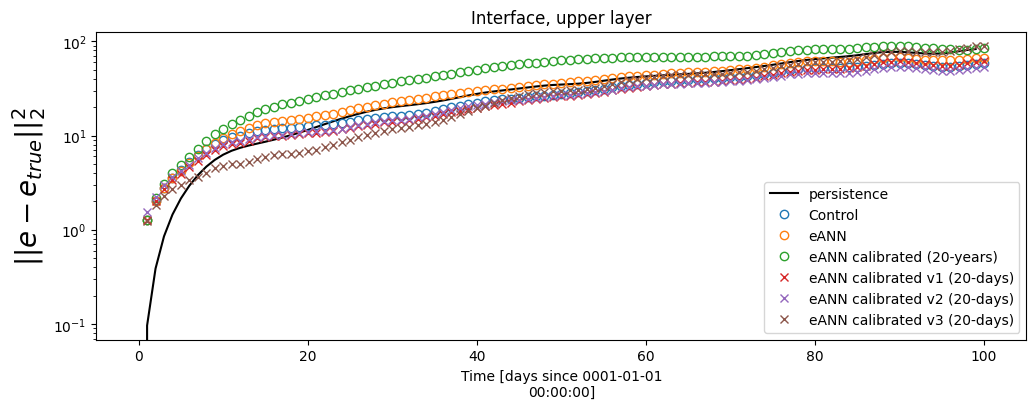

In [13]:
plt.figure(figsize=(12,4))
sel = lambda x: x.e.isel(zi=0)
xy = ['xh', 'yh']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v1 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='x', ls='', markerfacecolor='none')

plt.legend()
plt.ylabel('$||e - e_{true}||_2^2$', fontsize=20)
plt.title('Interface, upper layer')
plt.yscale('log')

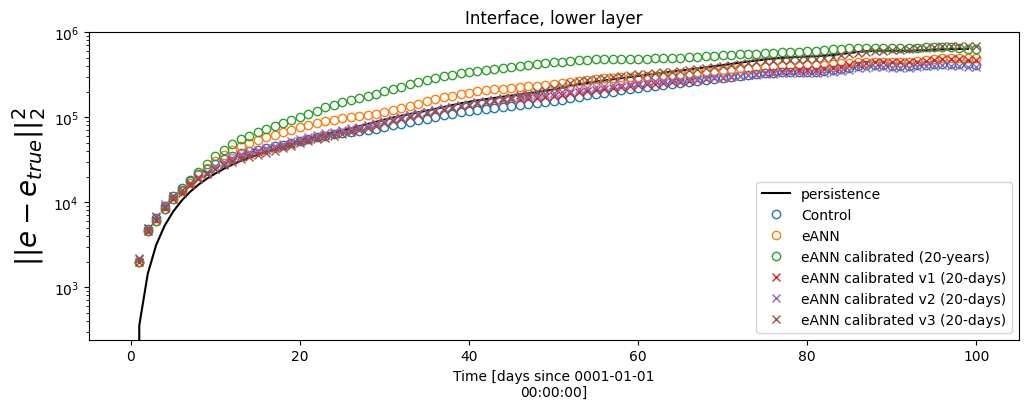

In [14]:
plt.figure(figsize=(12,4))
sel = lambda x: x.e.isel(zi=1)
xy = ['xh', 'yh']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v1 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='x', ls='', markerfacecolor='none')

plt.legend()
plt.ylabel('$||e - e_{true}||_2^2$', fontsize=20)
plt.title('Interface, lower layer')
plt.yscale('log')

Text(0.5, 1.0, 'Zonal velocity, upper layer')

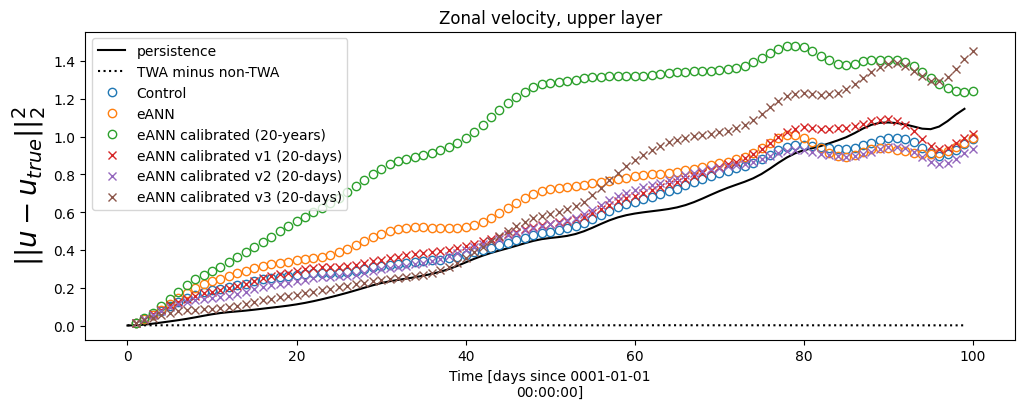

In [15]:
plt.figure(figsize=(12,4))
sel = lambda x: x.u.isel(zl=0)
xy = ['xq', 'yh']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((data['u'].isel(zl=0) - data['u_h'].isel(zl=0))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', ls=':', label='TWA minus non-TWA')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v1 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='x', ls='', markerfacecolor='none')


plt.legend()
plt.ylabel('$||u - u_{true}||_2^2$', fontsize=20)
plt.title('Zonal velocity, upper layer')

Text(0.5, 1.0, 'Meridional velocity, upper layer')

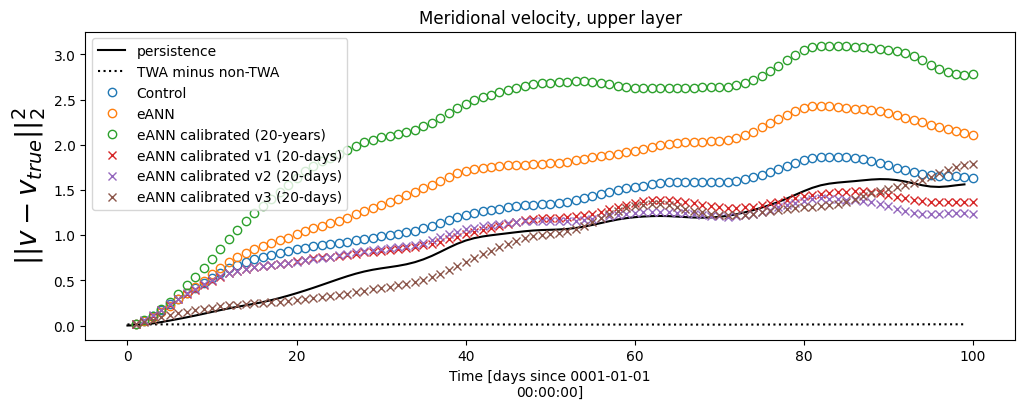

In [16]:
plt.figure(figsize=(12,4))
sel = lambda x: x.v.isel(zl=0)
xy = ['xh', 'yq']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((data['v'].isel(zl=0) - data['v_h'].isel(zl=0))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', ls=':', label='TWA minus non-TWA')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v1 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='x', ls='', markerfacecolor='none')


plt.legend()
plt.ylabel('$||v - v_{true}||_2^2$', fontsize=20)
plt.title('Meridional velocity, upper layer')

Text(0.5, 1.0, 'Zonal velocity, lower layer')

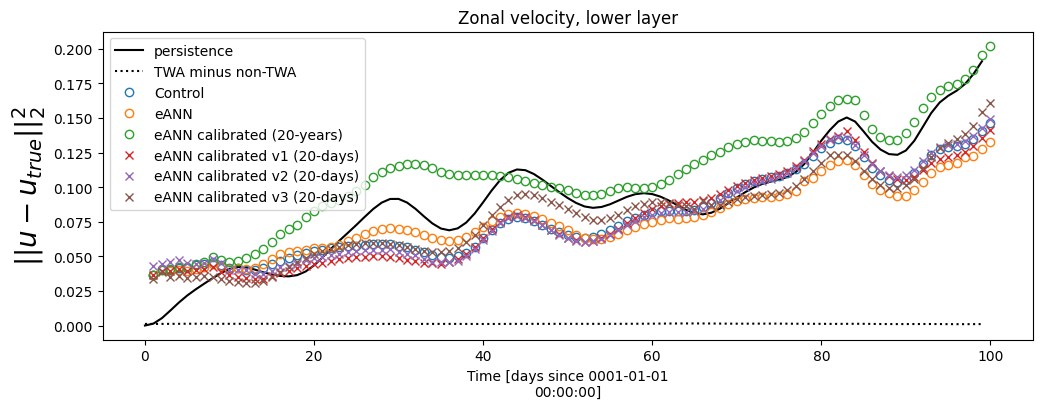

In [17]:
plt.figure(figsize=(12,4))
sel = lambda x: x.u.isel(zl=1)
xy = ['xq', 'yh']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((data['u'].isel(zl=0) - data['u_h'].isel(zl=0))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', ls=':', label='TWA minus non-TWA')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v1 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='x', ls='', markerfacecolor='none')


plt.legend()
plt.ylabel('$||u - u_{true}||_2^2$', fontsize=20)
plt.title('Zonal velocity, lower layer')

Text(0.5, 1.0, 'Meridional velocity, lower layer')

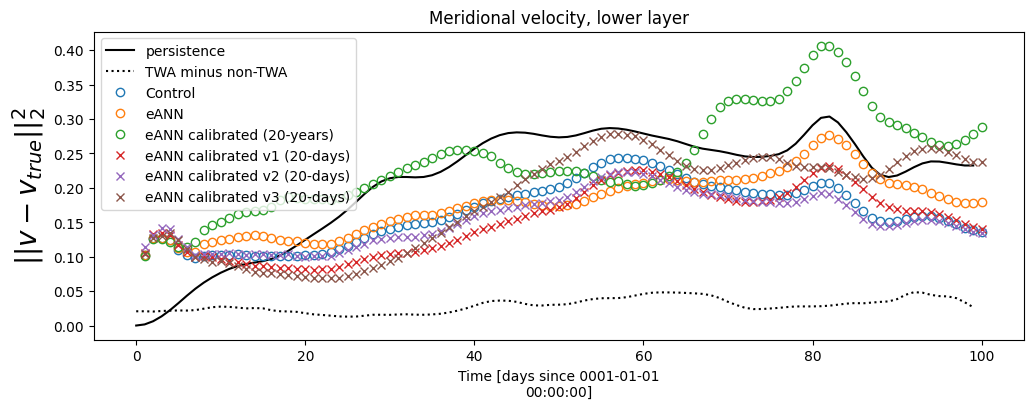

In [18]:
plt.figure(figsize=(12,4))
sel = lambda x: x.v.isel(zl=1)
xy = ['xh', 'yq']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((data['v'].isel(zl=1) - data['v_h'].isel(zl=1))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', ls=':', label='TWA minus non-TWA')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v1 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='x', ls='', markerfacecolor='none')


plt.legend()
plt.ylabel('$||v - v_{true}||_2^2$', fontsize=20)
plt.title('Meridional velocity, lower layer')

# Smoother metrics for lower. Predicting uh instead of h

In [19]:
# Introduce weighting factor
h_mean = data.h.mean('Time').compute()

In [20]:
lores_static = xr.open_mfdataset(f'/scratch/pp2681/mom6/Feb2022/bare/R2/output/ocean_geometry.nc').rename({'lonh': 'xh', 'lath': 'yh', 'lonq': 'xq', 'latq': 'yq'})

In [21]:
grid_lores = xgcm.Grid(lores_static, coords={
        'X': {'center': 'xh', 'outer': 'xq'},
        'Y': {'center': 'yh', 'outer': 'yq'}
        },
        boundary={'X': 'fill', 'Y': 'fill'},
        fill_value = {'Y': 0, 'X': 0})


In [22]:
hu = grid_lores.interp(h_mean, 'X')
hv = grid_lores.interp(h_mean, 'Y')

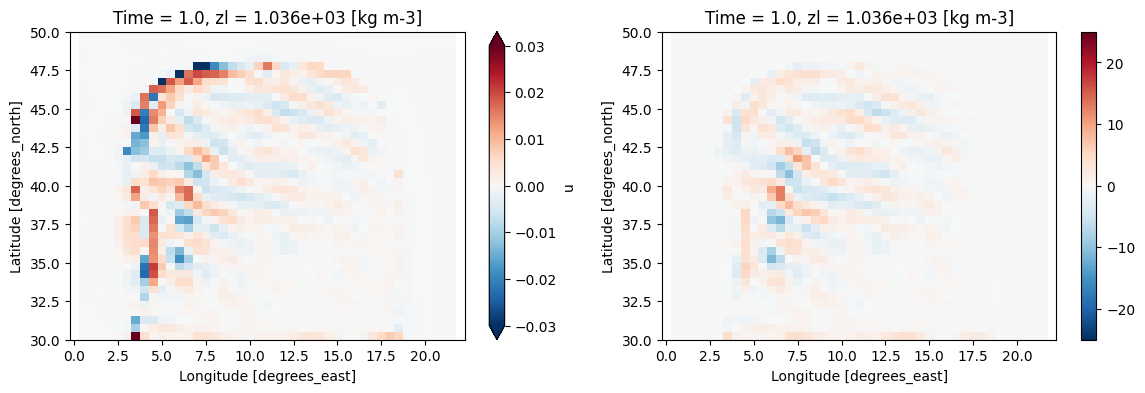

In [23]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
(data.u[1][1] - nonTWA.u[0][1]).plot(vmin=-0.03)

plt.subplot(1,2,2)
(hu[1] * (data.u[1][1] - nonTWA.u[0][1])).plot(vmin=-25)

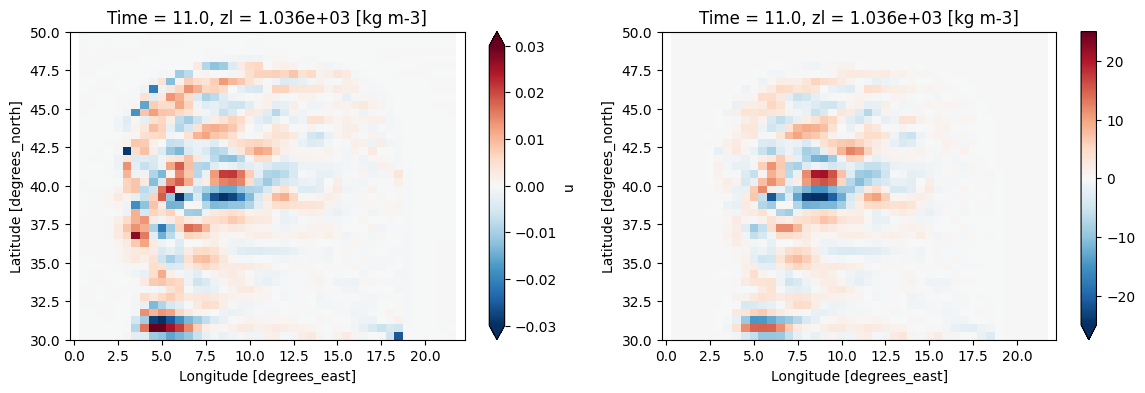

In [24]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
(data.u[11][1] - nonTWA.u[10][1]).plot(vmin=-0.03)

plt.subplot(1,2,2)
(hu[1] * (data.u[11][1] - nonTWA.u[10][1])).plot(vmin=-25)

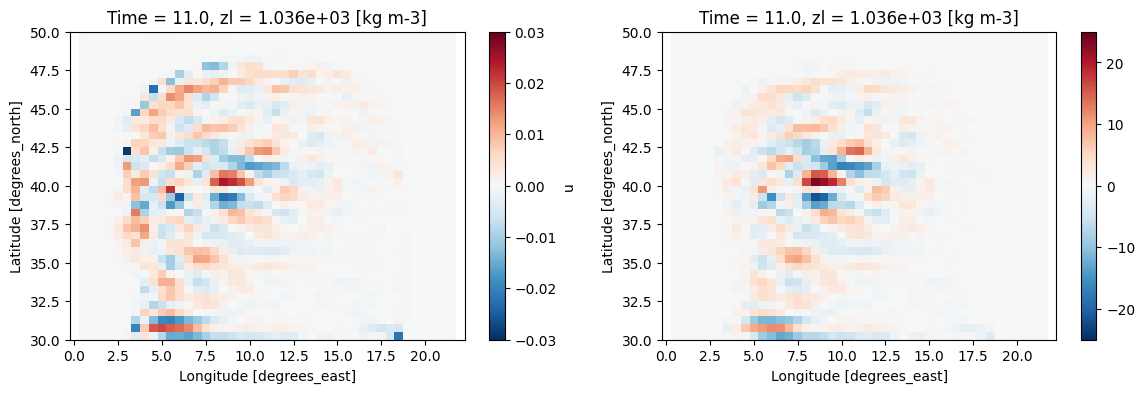

In [25]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
(data.u[11][1] - eANN_v3.u[10][1]).plot(vmin=-0.03)

plt.subplot(1,2,2)
(hu[1] * (data.u[11][1] - eANN_v3.u[10][1])).plot(vmin=-25)

Text(0.5, 1.0, 'Zonal velocity, lower layer')

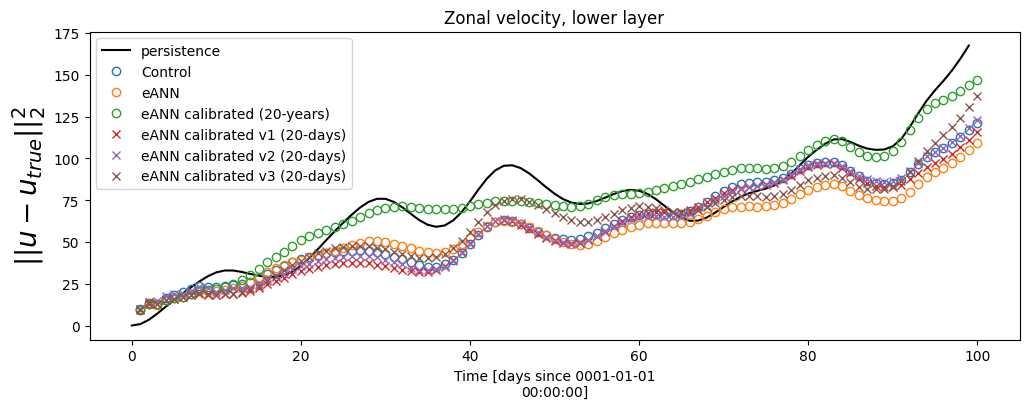

In [28]:
plt.figure(figsize=(12,4))
sel = lambda x: x.u.isel(zl=1) * np.sqrt(hu).isel(zl=1)
xy = ['xq', 'yh']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v1 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='x', ls='', markerfacecolor='none')


plt.legend()
plt.ylabel('$||u - u_{true}||_2^2$', fontsize=20)
plt.title('Zonal velocity, lower layer')

Text(0.5, 1.0, 'Meridional velocity, lower layer')

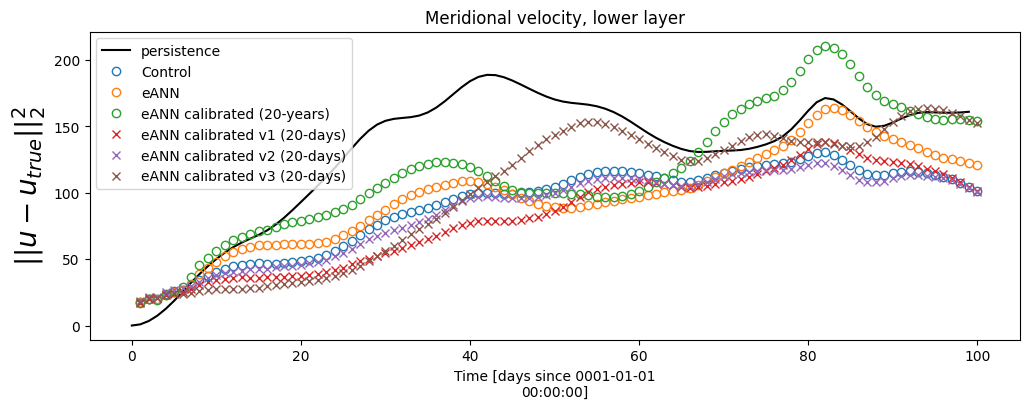

In [29]:
plt.figure(figsize=(12,4))
sel = lambda x: x.v.isel(zl=1) * np.sqrt(hv).isel(zl=1)
xy = ['xh', 'yq']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v1 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='x', ls='', markerfacecolor='none')


plt.legend()
plt.ylabel('$||u - u_{true}||_2^2$', fontsize=20)
plt.title('Meridional velocity, lower layer')

Text(0.5, 1.0, 'Zonal velocity, upper layer')

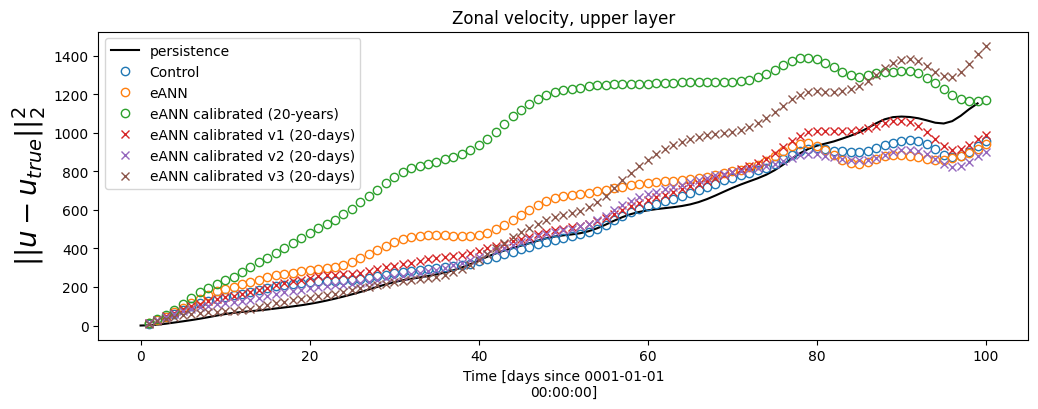

In [32]:
plt.figure(figsize=(12,4))
sel = lambda x: x.u.isel(zl=0) * np.sqrt(hu).isel(zl=0)
xy = ['xq', 'yh']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v1 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v3 (20-days)', marker='x', ls='', markerfacecolor='none')


plt.legend()
plt.ylabel('$||u - u_{true}||_2^2$', fontsize=20)
plt.title('Zonal velocity, upper layer')

Text(0.5, 1.0, 'Meridional velocity, upper layer')

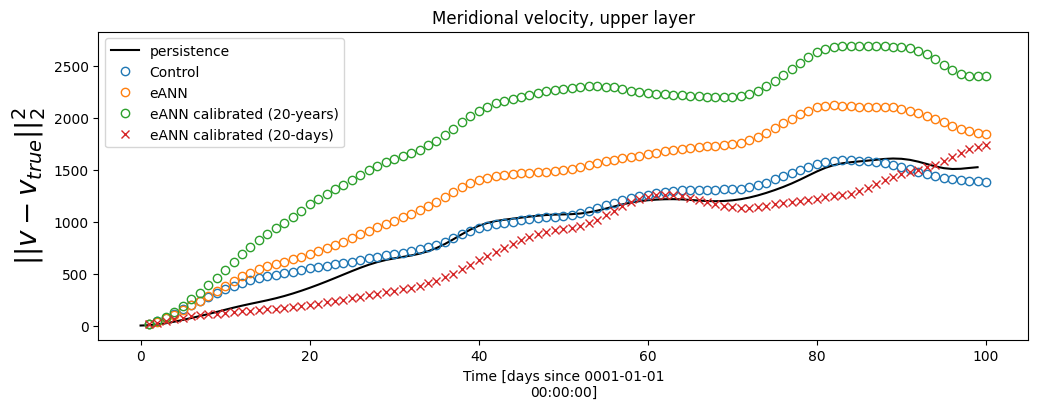

In [37]:
plt.figure(figsize=(12,4))
sel = lambda x: x.v.isel(zl=0) * np.sqrt(hv).isel(zl=0)
xy = ['xh', 'yq']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((sel(nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN', marker='o', ls='', markerfacecolor='none')
((sel(eANN_calibrated_nonTWA) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-years)', marker='o', ls='', markerfacecolor='none')
#((sel(eANN_v1) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v1 (20-days)', marker='x', ls='', markerfacecolor='none')
#((sel(eANN_v2) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated v2 (20-days)', marker='x', ls='', markerfacecolor='none')
((sel(eANN_v3) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-days)', marker='x', ls='', markerfacecolor='none')


plt.legend()
plt.ylabel('$||v - v_{true}||_2^2$', fontsize=20)
plt.title('Meridional velocity, upper layer')

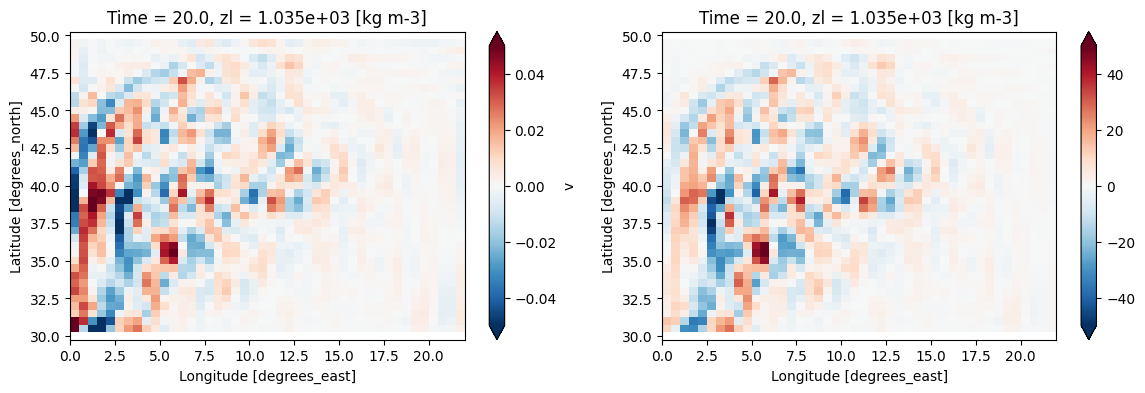

In [45]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
(data.v[20][0] - eANN_v3.v[19][0]).plot(vmin=-0.05)

plt.subplot(1,2,2)
(hv[0] * (data.v[20][0] - eANN_v3.v[19][0])).plot(vmin=-50)

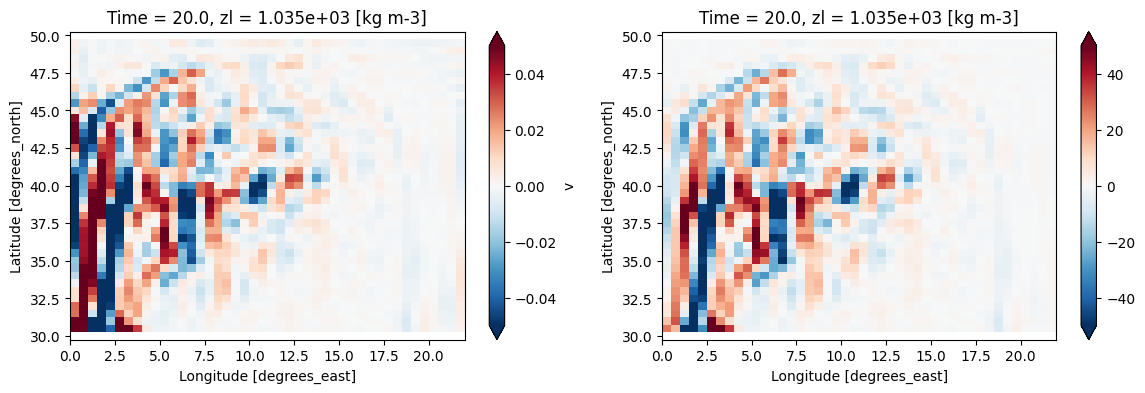

In [46]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
(data.v[20][0] - nonTWA.v[19][0]).plot(vmin=-0.05)

plt.subplot(1,2,2)
(hv[0] * (data.v[20][0] - nonTWA.v[19][0])).plot(vmin=-50)

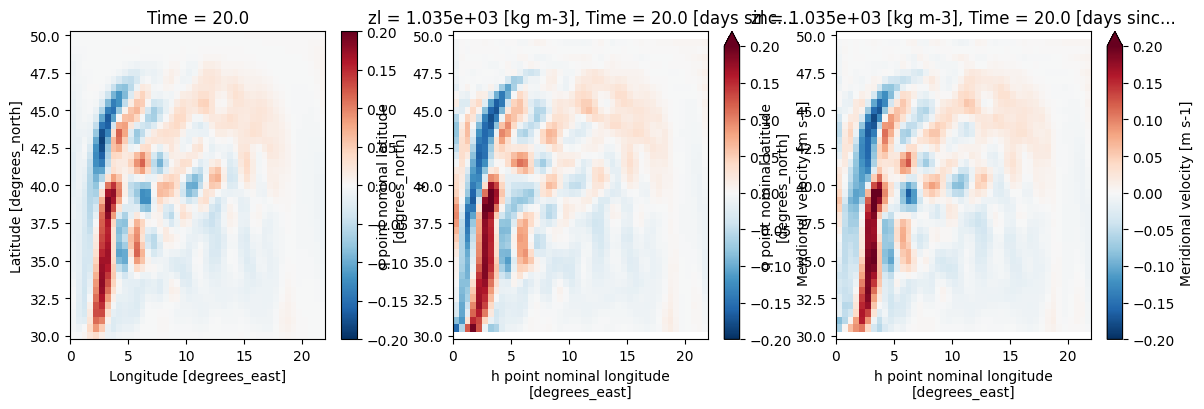

In [53]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
data.v[20][0].plot(vmin=-0.2)

plt.subplot(1,3,2)
nonTWA.v[19][0].plot(vmin=-0.2)

plt.subplot(1,3,3)
eANN_v3.v[19][0].plot(vmin=-0.2)

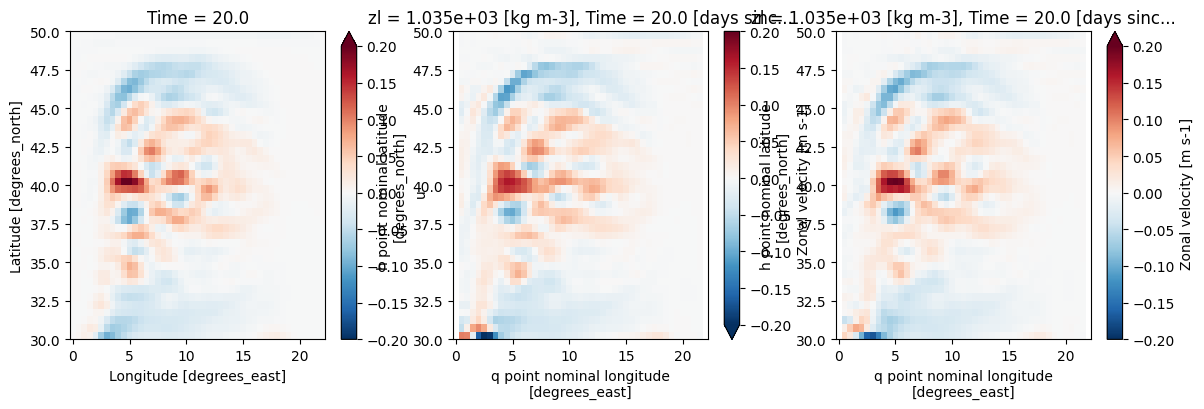

In [54]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
data.u[20][0].plot(vmin=-0.2)

plt.subplot(1,3,2)
nonTWA.u[19][0].plot(vmin=-0.2)

plt.subplot(1,3,3)
eANN_v3.u[19][0].plot(vmin=-0.2)

# Validation dataset

In [ ]:
data = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/high_frequency/*.nc', decode_times=False, combine='nested', concat_dim='Time').astype('float64').fillna(0.).sortby('Time')

In [60]:
data['Time'] = data['Time'] -  data['Time'].isel(Time=900)

In [61]:
data = data.isel(Time=slice(900,None))

In [64]:
control_900 = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/R2-non-TWA-time-900/prog_*', decode_times=False)
eANN_v3_900 = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/eANN-calibrated-20-days-u-h-weighted-full-time-900/prog_*', decode_times=False)

Text(0.5, 1.0, 'Meridional velocity, upper layer')

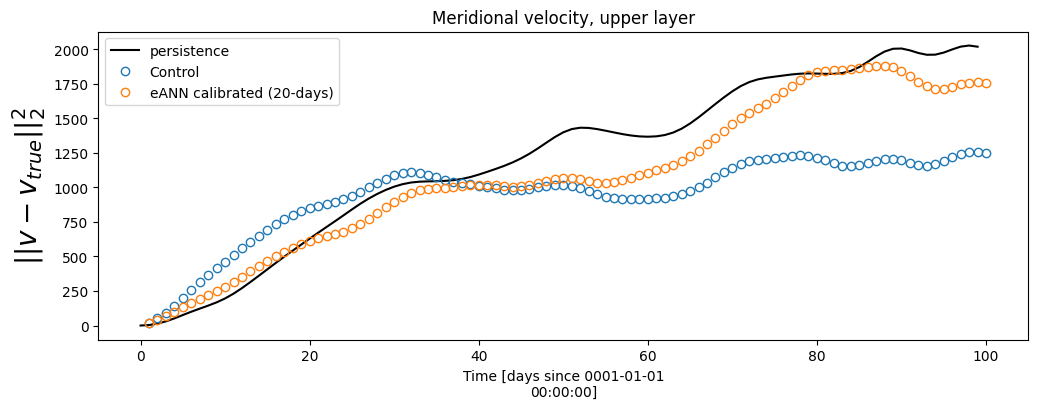

In [67]:
plt.figure(figsize=(12,4))
sel = lambda x: x.v.isel(zl=0) * np.sqrt(hv).isel(zl=0)
xy = ['xh', 'yq']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((sel(control_900) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v3_900) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-days)', marker='o', ls='', markerfacecolor='none')

plt.legend()
plt.ylabel('$||v - v_{true}||_2^2$', fontsize=20)
plt.title('Meridional velocity, upper layer')

Text(0.5, 1.0, 'Zonal velocity, upper layer')

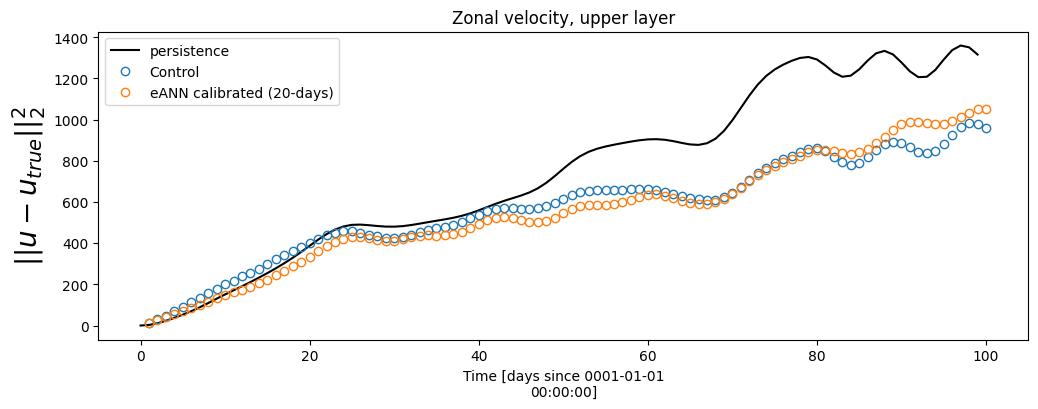

In [68]:
plt.figure(figsize=(12,4))
sel = lambda x: x.u.isel(zl=0) * np.sqrt(hu).isel(zl=0)
xy = ['xq', 'yh']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((sel(control_900) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v3_900) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-days)', marker='o', ls='', markerfacecolor='none')

plt.legend()
plt.ylabel('$||u - u_{true}||_2^2$', fontsize=20)
plt.title('Zonal velocity, upper layer')

Text(0.5, 1.0, 'Interface, upper layer')

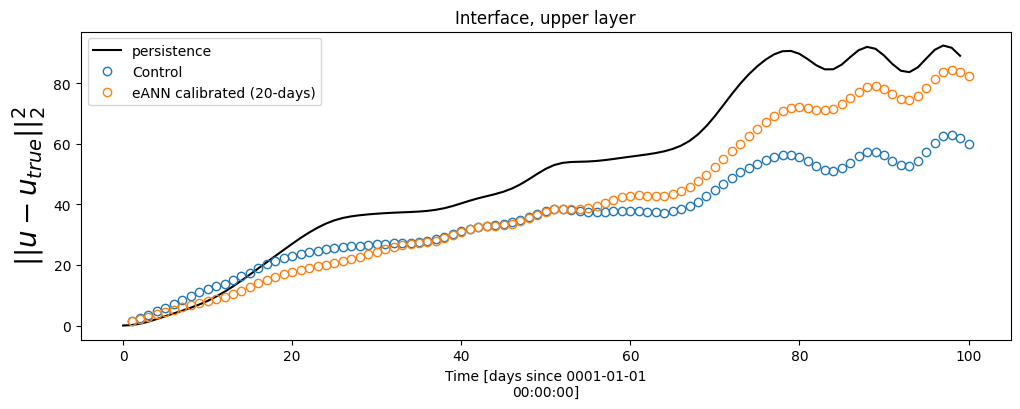

In [69]:
plt.figure(figsize=(12,4))
sel = lambda x: x.e.isel(zi=0)
xy = ['xh', 'yh']

((sel(data).isel(Time=0) - sel(data))**2).isel(Time=slice(0,100)).sum(xy).plot(color='k', label='persistence')
((sel(control_900) - sel(data))**2).sum(xy).plot(lw=2, label='Control', marker='o', ls='', markerfacecolor='none')
((sel(eANN_v3_900) - sel(data))**2).sum(xy).plot(lw=2, label='eANN calibrated (20-days)', marker='o', ls='', markerfacecolor='none')

plt.legend()
plt.ylabel('$||u - u_{true}||_2^2$', fontsize=20)
plt.title('Interface, upper layer')

In [143]:
# The errors introduced by the numerical model are so much larger than the difference between TWA and non-TWA velocities. Thus, information about the trajectory is more important than the details about filtering. So, we proceed with non-TWA framework for simplicitiy, starting with initial time moment, for 20 days.

# Dataset for online training

In [ ]:
EKI_dataset = data[['u', 'v']].isel(Time=slice(1,21))
# Simplest measures for the model error -- we use variance of time series
velocity_var = (data['u'].var('Time').mean(['xq', 'yh']) + data['v'].var('Time').mean(['xh', 'yq'])) * 0.5
EKI_dataset['u_var_ave'] = EKI_dataset['u']*0 + velocity_var
EKI_dataset['v_var_ave'] = EKI_dataset['v']*0 + velocity_var
# Introduce weighthing factor. It will be used to define the KE-norm in the EKI algorithm
# We will predict not velocity u, but u*sqrt(h), where sqrt(h) is a time-average. We 
# also get rid of upweighting the lower layer
EKI_dataset['hu'] = grid_lores.interp(data['h'], 'X').mean('Time')
EKI_dataset['hv'] = grid_lores.interp(data['h'], 'Y').mean('Time')
EKI_dataset['u_sqrt_h'] = EKI_dataset['u'] * np.sqrt(EKI_dataset['hu'])
EKI_dataset['v_sqrt_h'] = EKI_dataset['v'] * np.sqrt(EKI_dataset['hv'])

In [66]:
EKI_dataset = EKI_dataset.compute()

In [67]:
EKI_dataset.to_netcdf('../scripts/R32/R2_FGR3_online_training.nc')

# 20-days versus 20-years metrics in initial ensemble

In [100]:
y20 = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/20-years/R2_FGR3/metrics.nc').isel(iter=0).isel(res=0)

In [101]:
d20 = xr.open_dataset('/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/online_training/R2_FGR3_test/metrics.nc').isel(iter=0).isel(res=0)

In [102]:
np.abs(d20.param - y20.param).max()

<xarray.DataArray 'param' ()> Size: 4B
array(0., dtype=float32)

In [103]:
# First metric
RMSE_ssh_mean = y20.RMSE_e_mean.isel(zi=0).values

In [104]:
# First metric
RMSE_ssh_std = y20.RMSE_e_std.isel(zi=0).values

In [105]:
data = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/filtered/R32_R2_FGR3/high_frequency/*.nc', decode_times=False, combine='nested', concat_dim='Time').astype('float64').fillna(0.).sortby('Time')
data['Time'] = data['Time'] -  data['Time'].isel(Time=0)

In [106]:
RMSE_ssh_20d = xr.DataArray(np.zeros((100)) * np.nan, dims=['ens'])
for ens_member in range(100):
    try:
        ssh = xr.open_dataset(f'/scratch/pp2681/mom6/CM26_Double_Gyre/calibration/online_training/R2_FGR3_test/iteration-00/R2/ens-member-{ens_member:02d}/output/prog__0001_002.nc').e.isel(zi=0)
        error = ssh.values - data.e.isel(Time=slice(1,21)).isel(zi=0).values
        RMSE_ssh_20d[ens_member] = np.sqrt((error**2).mean())
    except:
        pass

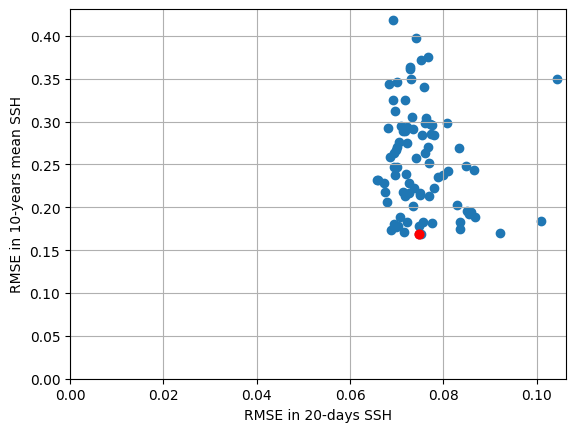

In [107]:
plt.scatter(RMSE_ssh_20d, RMSE_ssh_mean)
plt.xlim([0,None])
plt.ylim([0,None])
plt.grid()
plt.xlabel('RMSE in 20-days SSH')
plt.ylabel('RMSE in 10-years mean SSH')
plt.scatter(
    RMSE_ssh_20d[8],
    RMSE_ssh_mean[8],
    color='red', label="Pareto front", s=40
)

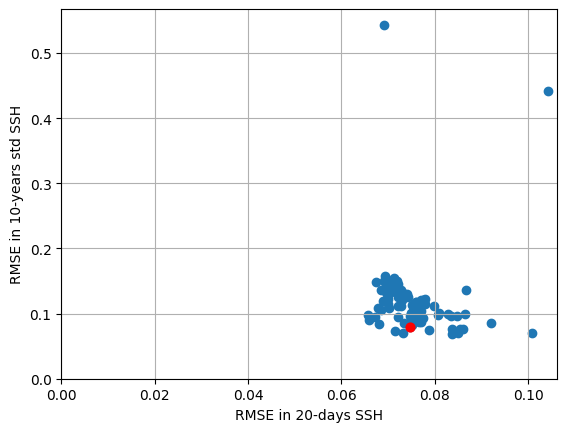

In [108]:
plt.scatter(RMSE_ssh_20d, RMSE_ssh_std)
plt.xlim([0,None])
plt.ylim([0,None])
plt.grid()
plt.xlabel('RMSE in 20-days SSH')
plt.ylabel('RMSE in 10-years std SSH')
plt.scatter(
    RMSE_ssh_20d[8],
    RMSE_ssh_std[8],
    color='red', label="Pareto front", s=40
)

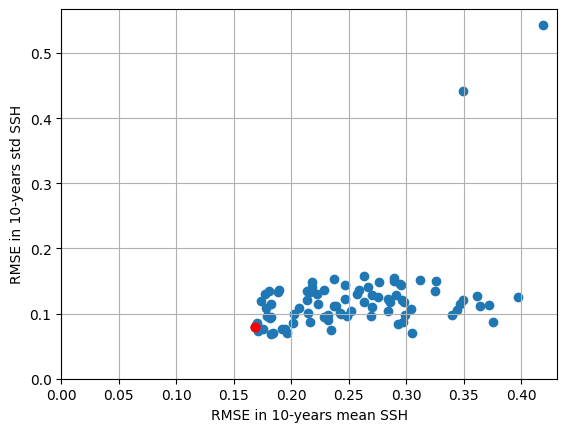

In [109]:
plt.scatter(RMSE_ssh_mean, RMSE_ssh_std)
plt.xlim([0,None])
plt.ylim([0,None])
plt.grid()
plt.xlabel('RMSE in 10-years mean SSH')
plt.ylabel('RMSE in 10-years std SSH')
plt.scatter(
    RMSE_ssh_mean[8],
    RMSE_ssh_std[8],
    color='red', label="Pareto front", s=40
)

# Pareto front w.r.t. three metrics

In [110]:
RMSE_ssh_20d = RMSE_ssh_20d.values
RMSE_ssh_mean = np.nan_to_num(RMSE_ssh_mean,nan=1e+20)
RMSE_ssh_std = np.nan_to_num(RMSE_ssh_std,nan=1e+20)

In [111]:
import numpy as np

metrics = np.column_stack((
    RMSE_ssh_mean,
    RMSE_ssh_std,
    RMSE_ssh_20d
))

def pareto_min(points):
    N = points.shape[0]
    is_pareto = np.ones(N, dtype=bool)

    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            # j dominates i  (MINIMIZATION)
            if np.all(points[j] <= points[i]) and np.any(points[j] < points[i]):
                is_pareto[i] = False
                break

    return is_pareto

mask = pareto_min(metrics)
pareto_points = metrics[mask]


In [112]:
pareto_indices = np.where(mask)[0]


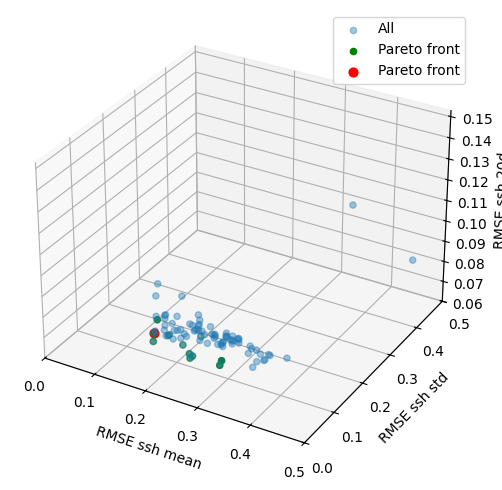

In [113]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    RMSE_ssh_mean, RMSE_ssh_std, RMSE_ssh_20d,
    alpha=0.4, label="All"
)

ax.scatter(
    RMSE_ssh_mean[mask],
    RMSE_ssh_std[mask],
    RMSE_ssh_20d[mask],
    color='green', label="Pareto front"
)

ax.scatter(
    RMSE_ssh_mean[mask][1],
    RMSE_ssh_std[mask][1],
    RMSE_ssh_20d[mask][1],
    color='red', label="Pareto front", s=40
)

ax.set_xlabel("RMSE ssh mean")
ax.set_ylabel("RMSE ssh std")
ax.set_zlabel("RMSE ssh 20d")
ax.set_xlim([0,0.5])
ax.set_ylim([0,0.5])
ax.legend()
plt.show()


In [114]:
assert mask[np.argmin(RMSE_ssh_mean)]
assert mask[np.argmin(RMSE_ssh_std)]
assert mask[np.argmin(RMSE_ssh_20d)]


In [115]:
pareto_points = metrics[mask]

In [116]:
mask

array([False, False, False,  True, False, False, False, False,  True,
       False,  True,  True, False, False,  True, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False])

In [117]:
pareto_points

array([[0.1738819 , 0.11940443, 0.06886186],
       [0.16875818, 0.07896689, 0.07465493],
       [0.30486983, 0.07042012, 0.07323302],
       [0.23190039, 0.09033927, 0.06590304],
       [0.23196296, 0.09826409, 0.06580411],
       [0.20670167, 0.1089462 , 0.06783443],
       [0.22826572, 0.0945336 , 0.06718607],
       [0.17078134, 0.07320684, 0.07158964],
       [0.17782685, 0.10922553, 0.07015908],
       [0.21783081, 0.14879681, 0.0674742 ],
       [0.18234882, 0.06899953, 0.08362147],
       [0.29285711, 0.08470763, 0.06804683]])